# Project of image analysis --- Handwriting recognition

## Import packages and load data

In [29]:
!sudo apt install tesseract-ocr
!pip install pytesseract
from pytesseract import image_to_string
import os
os.sys.path
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import misc
import numpy as np
from google.colab.patches import cv2_imshow
from os import listdir
from os.path import isfile, join

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## part 1. Preprocess Image

In [31]:
carpenter_path = '/content/drive/MyDrive/Project of Image Analysis/image/carpenter.jpg'
test_path = '/content/drive/MyDrive/Project of Image Analysis/testimages/test6.jpg'
image = cv2.imread(carpenter_path)
test_image = cv2.imread(test_path)
image = cv2.resize(image, (1470,365),interpolation = cv2.INTER_AREA)
t_image = cv2.resize(test_image, (1470,365),interpolation = cv2.INTER_AREA)

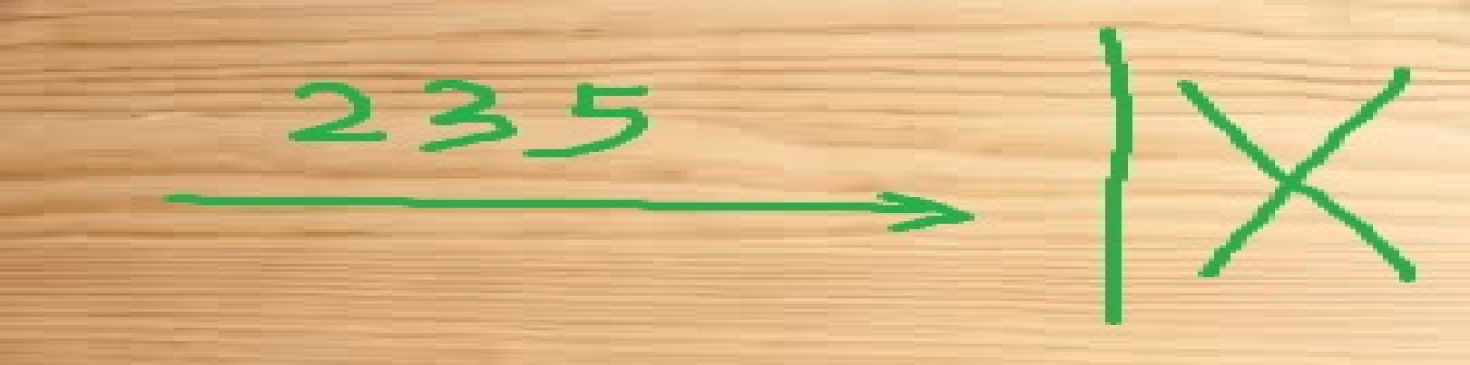

In [32]:
cv2_imshow(t_image)

## Functions

In [33]:
def preprocessing(img):  # using color detection get the all the symbols
    #HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # define range of green color in HSV
    lower_green = np.array([25,20,0])
    upper_green = np.array([100,200,250])

    # Threshold the HSV image to get only green colors
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(img,img, mask= mask)   
    res = cv2.medianBlur(res,15)
    # cv2_imshow(imgMedianBlur)
    return res


def finding_Contours(image):
    #blur
    median_blur = cv2.medianBlur(image,3)
     
    #cv2_imshow(median_blur)

    #find edges with Canny
    edge = cv2.Canny(median_blur,100,170)
    # cv2_imshow(edge)

    #find and sort contours
    contours, h = cv2.findContours(edge, 
                               cv2.RETR_EXTERNAL,
                               cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    return contours[:10]


def draw_contours(image):  
    # Iterate over the output "lines" and draw lines on the blank   
    # Draw all contours 
    # -1 signifies drawing all contours 
    image_contours = cv2.drawContours(image, contours, -1, (0, 255, 0), 3) 
    
    print("Number of contours = " + str(len(contours)))
    return  image_contours


def centroid(cnt):
    moment = cv2.moments(cnt)
    x = int(moment ["m10"] / moment["m00"])
    y = int(moment ["m01"] / moment["m00"])
    cv2.circle(img, (X, Y), 15, (205, 114, 101), 1)
    return x,y


def single_out_symbols(image):  #??? how to get the digits completely?
  height, width = image.shape[:2]
  black = np.zeros((height,width,3), dtype = "uint8")
  contours = finding_Contours(image)
  imgs = []
  for i in range(0, len(contours)):
    img = black.copy()
    cnt = contours[i]
    cv2.drawContours(img, cnt, -1, (255,255,255), thickness = 3) 
    cv2.fillPoly(img, pts =[cnt], color=(255,255,255))
    # cv2_imshow(img)
    # cv2.imwrite('cnt'+ str(i)+'.jpg',img)
    imgs.append(img)
  return imgs[:10]


In [34]:
#get the coordinates of symbols in order to cut the corresponding  symbol from original image
def bounding_coordinates(img,original_img): 
  image = resize(original_img)
  contours, h = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  x,y,w,h = 0,0,0,0
  for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
  imgCropped = image[y:y+h,x:x+w]
  return imgCropped

#load dataset images
def load_imgs(path):
  onlyfiles = [ f for f in listdir(path) if isfile(join(path,f)) ]
  images = np.empty(len(onlyfiles), dtype=object)
  for n in range(0, len(onlyfiles)):
    images[n] = cv2.imread( join(path,onlyfiles[n]) )
  return images


def rotation(img,degree):  # rotate 180 degree
  (h, w) = img.shape[:2] 
  center = (w // 2, h // 2)
  M = cv2.getRotationMatrix2D(center, degree, 1.0) 
  rotated = cv2.warpAffine(img, M, (w, h))
  return rotated

# set the size as 365, 1470
def resize(img):
  width, height = 400, 100
  resized = cv2.resize(img, (width,height),interpolation = cv2.INTER_AREA)
  image = resized.reshape(height, width, 1)
  return image

def input_standardization(imgs):
  standard_imgs = imgs[0][np.newaxis,:]
  for i in range(1,len(imgs)):
    A = imgs[i][np.newaxis,:]
    standard_imgs = np.vstack((standard_imgs,A))
  return standard_imgs

def standard_background(image):
  height, width = image.shape[:2]
  black = np.zeros((365,1470,1), dtype = "uint8")
  x = int((1470 - width)/2)
  y = int((365 - height)/2)
  x2 = int((1470 + width)/2)
  y2 = int((365 + height)/2)
  image = image.reshape(height,width,1)
  black[y:y2, x:x2] = image
  img = resize(black)
  return img

def preprocessing_symbols(img):
  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #HSV
  lower_black = np.array([0,0,0])
  upper_black = np.array([200,100,125])
  
  # Threshold the HSV image to get only blue colors
  mask = cv2.inRange(hsv, lower_black, upper_black)

  # Bitwise-AND mask and original image
  res = cv2.bitwise_and(img,img, mask= mask)
  
  #tresholding
  kernel = np.ones((5,5),np.uint8)
  gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)

  ret,thresh1 = cv2.threshold(gray,0,255,cv2.THRESH_BINARY)
  dilation = cv2.dilate(thresh1,kernel,iterations = 1)
  image = standard_background(dilation)

  # return dilation
  return image

# input original image and transfer it to image of single symbols
def split_symbols(img): 
  image = preprocessing(img) # color detection
  image = cv2.resize(image, (1470,365),interpolation = cv2.INTER_AREA)
  height, width = image.shape[:2]
  black = np.zeros((height,width,1), dtype = "uint8")
  contours = finding_Contours(image)
  # cv2_imshow(image)
  positions = []
  imgs = []
  for i in range(0, len(contours)):
    img = black.copy()
    cnt = contours[i]
    cv2.drawContours(img, cnt, -1, (255,255,255), thickness = 3) 
    cv2.fillPoly(img, pts =[cnt], color=(255,255,255))
    # cv2_imshow(img)
    x,y,w,h = cv2.boundingRect(cnt)
    positions.append([x,y,w,h])
    imgCropped = img[y:y+h,x:x+w]
    img = standard_background(imgCropped)
    imgs.append(img)
  return input_standardization(imgs), np.array(positions)

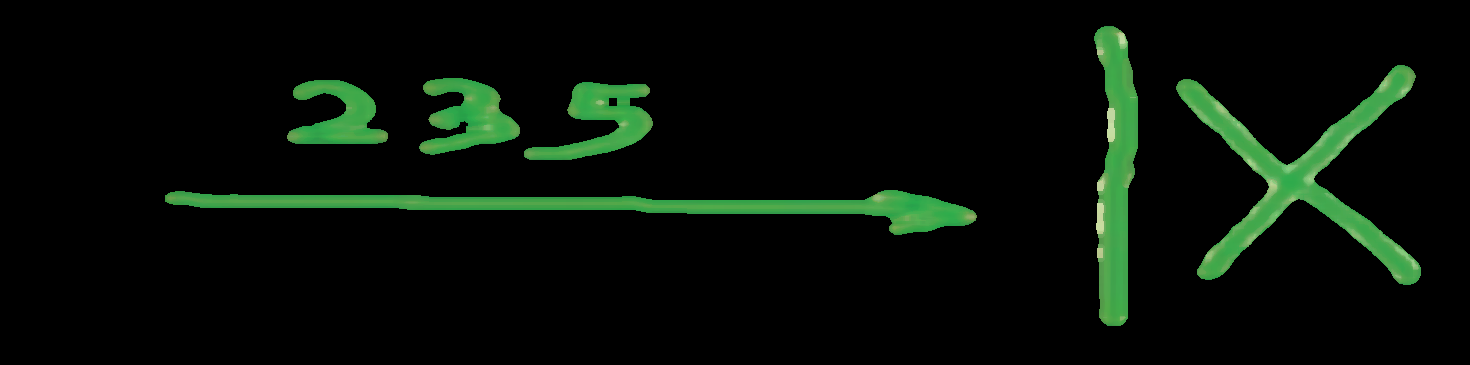

In [35]:
# test
a = preprocessing(t_image)
cv2_imshow(a)
# # #finding_Contours(a)
# imgs = single_out_symbols(a)
# for img in imgs:
#   cv2_imshow(img)

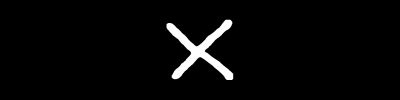

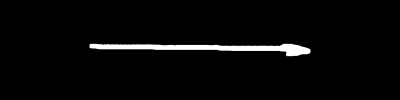

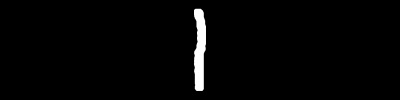

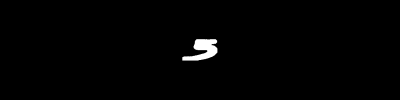

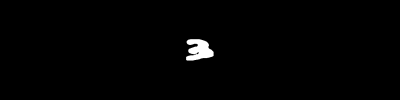

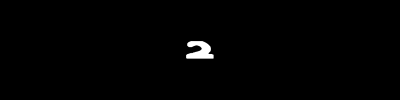

In [36]:
# test
# imgs = single_out_symbols(t_image)
imgs, positions = split_symbols(t_image)
for i in range(0,len(imgs)):
  cv2_imshow(imgs[i])

## part 2. Detected three symbols : dimension line, cut line and X symbol

###Prepare datasets

In [ ]:
image_path = '/content/drive/MyDrive/Project of Image Analysis/image/carpenter.jpg'
img=cv2.imread(image_path)

In [ ]:
image_x_path = '/content/drive/MyDrive/Project of Image Analysis/X'
image_arrow_path = '/content/drive/MyDrive/Project of Image Analysis/Arrow'
image_verticalLine_path = '/content/drive/MyDrive/Project of Image Analysis/Vertical line'

In [ ]:
images_X = load_imgs(image_x_path)
images_arrow = load_imgs(image_arrow_path)
images_vline = load_imgs(image_verticalLine_path)

In [ ]:
# extend images of arrow by rotation
n = len(images_arrow)
images_arrow_extend = np.empty(2*n, dtype=object)
for i in range(0,n):
  rotated = rotation(images_arrow[i],180) # rotate 180 degree
  images_arrow_extend[i] = images_arrow[i]
  images_arrow_extend[n+i] = rotated

# extend images of vertical line
n = len(images_vline)
images_vline_extend = np.empty(2*n, dtype = object)
for i in range(0,n):
  rotated = rotation(images_vline[i],90) # rotate 90 degree
  images_vline_extend[i] = images_vline[i]
  images_vline_extend[n+i] = rotated 

# extend images of X
n = len(images_X)
images_X_extend = np.empty(2*n, dtype = object)
for i in range(0,n):
  rotated = rotation(images_X[i],90) # rotate 90 degree
  images_X_extend[i] = images_X[i]
  images_X_extend[n+i] = rotated

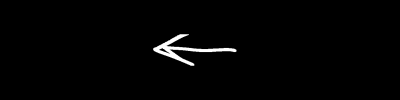

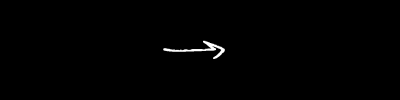

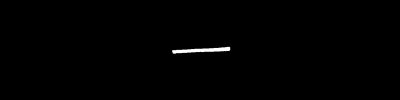

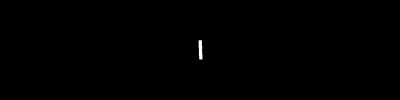

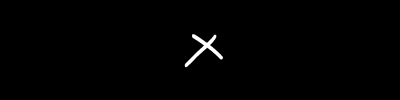

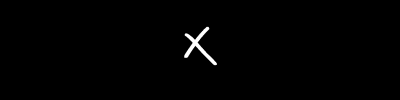

In [ ]:
# test
cv2_imshow(preprocessing_symbols(images_arrow_extend[len(images_arrow_extend)-1]))
cv2_imshow(preprocessing_symbols(images_arrow_extend[0]))
cv2_imshow(preprocessing_symbols(images_vline_extend[0]))
cv2_imshow(preprocessing_symbols(images_vline_extend[len(images_vline)-0]))
cv2_imshow(preprocessing_symbols(images_X_extend[0]))
cv2_imshow(preprocessing_symbols(images_X_extend[len(images_X)-0]))

### Build the datasets

In [ ]:
len_X, len_arrow, len_vline = len(images_X_extend), len(images_arrow_extend), len(images_vline_extend)
n = len_X + len_arrow + len_vline
X = np.empty(n, dtype = object)
y = np.empty(n,dtype = int)
for i in range(0,n):
  if i<len_X:
    X[i] = preprocessing_symbols(images_X_extend[i])
    y[i] = 1
  elif i< len_X + len_arrow:
    X[i] = preprocessing_symbols(images_arrow_extend[i - len_X])
    y[i] = 2
  elif i< n:
    X[i] = preprocessing_symbols(images_vline_extend[i - len_X - len_arrow])
    y[i] = 3

In [ ]:
X_new = X[0][np.newaxis,:]
for i in range(1,len(X)):
  A = X[i][np.newaxis,:]
  X_new = np.vstack((X_new,A))

X_new.shape

(914, 100, 400, 1)

In [ ]:
!pip install -U sklearn
from sklearn.model_selection import train_test_split
# #x is the features of data，y is the labels.
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.2, shuffle = True)

Requirement already up-to-date: sklearn in /usr/local/lib/python3.6/dist-packages (0.0)


### CNN model building

In [ ]:
# building cnn model
cnn = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(100,400,1)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
])

cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
cnn.fit(X_train, y_train, epochs=4)

Epoch 1/4
23/23 [==============================] - 31s 1s/step - loss: 7.2390 - accuracy: 0.7162
Epoch 2/4
23/23 [==============================] - 30s 1s/step - loss: 0.0361 - accuracy: 0.9905
Epoch 3/4
23/23 [==============================] - 30s 1s/step - loss: 9.2022e-04 - accuracy: 0.9997
Epoch 4/4
23/23 [==============================] - 30s 1s/step - loss: 1.3398e-04 - accuracy: 1.0000


In [ ]:
cnn.evaluate(X_test,y_test)

5/5 [==============================] - 27s 5s/step - loss: 0.4131 - accuracy: 0.9935


[0.41313251852989197, 0.9935064911842346]

In [ ]:
model_path = '/content/drive/MyDrive/Project of Image Analysis/model/cnn.h5'
cnn.save(model_path)

### Use model

In [37]:
# load model
model_path = '/content/drive/MyDrive/Project of Image Analysis/model/cnn.h5'
cnn_model = models.load_model(model_path)

In [38]:
classes = ['digits','X_symbol','arrow_line','cutline']

In [39]:
# symbols identification
def symbols_identification(img):
  clean_image = preprocessing(img) # using color detection to get clean image 
  img_symbols, positions = split_symbols(clean_image)
  y_pred = cnn_model.predict(img_symbols)
  # print(y_pred)
  y_classes = [np.argmax(element) for element in y_pred.T]
  # print(y_classes)
  symbols_index = y_classes[1:]
  # extract information
  three_symbols = img_symbols[symbols_index]
  symbol_positions = positions[symbols_index]
  digit_positions = np.delete(positions,symbols_index, axis = 0)
  x = np.min(digit_positions[:,0])
  y = np.min(digit_positions[:,1])
  w = np.max(digit_positions[:,2])
  h = np.max(digit_positions[:,3])
  x2 = np.max(digit_positions[:,2] + digit_positions[:,0])
  y2 = np.max(digit_positions[:,3] + digit_positions[:,1])
  digit_position = x,y,x2,y2
  return three_symbols,symbol_positions,digit_position

In [40]:
three_symbols, symbol_positions, digit_position = symbols_identification(t_image)

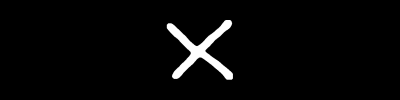

X_symbol


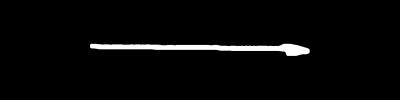

arrow_line


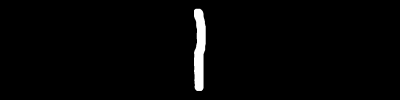

cutline


In [41]:
for i in range(0,len(three_symbols)):
  cv2_imshow(three_symbols[i])
  print(classes[i+1])

## part 3. Then detect the last symbol 

In [ ]:
# get digit symbol by removing other 3 symbols
def extract_digits_2(symbol_positions,image):
  hsv_image = preprocessing(image)
  for position in symbol_positions:
    x,y,w,h = position
    black = np.zeros((h,w,3), dtype = "uint8")
    # x = int((length - width)/2)
    # y = int((length - height)/2)
    # x2 = int((length + width)/2)
    # y2 = int((length + height)/2)
    # image = image.reshape(height,width,1)
    hsv_image[y:y+h, x:x+w] = black
    imgMedianBlur = cv2.medianBlur(hsv_image,11)
  return imgMedianBlur

def extract_digits(digit_position,original_img):
  x,y,x2,y2 = digit_position
  digit_img = original_img[y:y2,x:x2]
  # cv2_imshow(digit_img)
  return digit_img


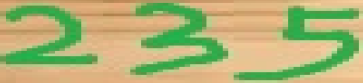

In [42]:
digit_img = extract_digits(digit_position, t_image)
cv2_imshow(digit_img)

In [ ]:
# test
clean_digits = preprocess_digits(digit_img)
# cv2_imshow(clean_digits[1])
len(clean_digits)

30

### step 3.3 Save the cropped digit image in local

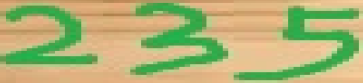

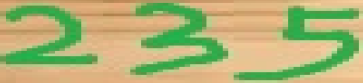

-1

In [ ]:
import cv2

# im = cv2.imread('test3.png')
im = digit_img
gray =cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
contours, hierarchy = cv2.findContours(gray,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
idx =0 
for cnt in contours:
    idx += 1
    x,y,w,h = cv2.boundingRect(cnt)
    roi=im[y:y+h,x:x+w]
    cv2_imshow(roi)
    cv2.imwrite(str(idx) + '.jpg', roi)
# cv2.imshow('img',im)
cv2_imshow(im)
cv2.waitKey(0) 

## part 4. Run MNIST algorithm.

### step 4.1 Load data from MNIST

In [ ]:
# load data and split them into train and test sets
mnist = tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test) = mnist.load_data()

x_train = tf.keras.utils.normalize(x_train, axis = 1)
x_test = tf.keras.utils.normalize(x_test, axis = 1)

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
print(x_train.shape,x_test.shape)

(60000, 28, 28) (10000, 28, 28)


### step 4.2 Build the CNN model


In [ ]:
# building the cnn model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape = (28,28)))
model.add(tf.keras.layers.Dense(units=128, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(units=128, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(units=10, activation = tf.nn.softmax))

### step 4.3 Training model

In [ ]:
# training model
print('start training...')
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

model.fit(x_train,y_train,epochs = 5)
loss, accuracy = model.evaluate(x_test, y_test)

print(accuracy)
print(loss)

start training...
Epoch 1/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4665 - accuracy: 0.8697
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1120 - accuracy: 0.9655
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0748 - accuracy: 0.9768
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0500 - accuracy: 0.9837
Epoch 5/5
313/313 [==============================] - 1s 1ms/step - loss: 0.0973 - accuracy: 0.9723
0.9722999930381775
0.09732991456985474


### step 4.4 Test the model, and evaluate it. 

In [ ]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0973 - accuracy: 0.9723


[0.09732991456985474, 0.9722999930381775]

In [ ]:
digit_model = model

In [ ]:
model.save('/content/drive/MyDrive/Project of Image Analysis/model/digit.h5')

## part 5. Classify the digit, one by one


In [114]:
model_path = '/content/drive/MyDrive/Project of Image Analysis/model/digit.h5'
digit_model = models.load_model(model_path)


In [ ]:
def classify_digits(digits_list):
  for d in digits_list:
    # resize the picture
    crop_size = (28, 28)
    img = cv2.resize(d, crop_size, interpolation = cv2.INTER_CUBIC)
    img = np.invert(np.array([img]))

    # img.shape
    prediction = digit_model.predict(img)
    print(f'prediction result: {np.argmax(prediction)}')
    # plt.imshow(img[0],cmap = plt.cm.binary)
    # plt.imshow(img[0])
    plt.show()

# def digits_classification(digit_img):



### step 5.1 Separate digits to single ones.

In [137]:
#the output is each number within a black box
def preprocess_digits(img):
  def resize(img):
    width, height = 28, 28
    resized = cv2.resize(img, (width,height),interpolation = cv2.INTER_AREA)
    # image = resized.reshape(height, width, 1)
    # img = np.invert(np.array([resized]))
    img = resized.reshape(28,28,1)
    return img
    
  grayy = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # cv2_imshow(grayy)
  #grayscale and tresholding
  ret, mask = cv2.threshold(grayy, 125, 255, cv2.THRESH_BINARY)
  # ret, mask = cv2.threshold(img, 140, 255, cv2.THRESH_BINARY)
  mask_inv = cv2.bitwise_not(mask)

  # cv2_imshow(mask_inv)

  #add bounding boxes
  # Draw rectangle and save each ROI and add border
  cnts = cv2.findContours(mask_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]
 
  value = (200, 200, 200)
  x_position = []
  digits = []
  # for c in sorted_ctrs:
  for c in cnts:
      x,y,w,h = cv2.boundingRect(c)
      x_position.append(x)
      img = cv2.rectangle(grayy, (x, y), (x + w, y + h), (255,255,255), 2)
      ROI = grayy[y:y+h, x:x+w]
      # cv2_imshow(ROI)
 
      ret, mask = cv2.threshold(ROI, 140, 255, cv2.THRESH_BINARY)
      mask_inv = cv2.bitwise_not(mask)
      border_image = cv2.copyMakeBorder(mask_inv, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value)

      digits.append(resize(border_image))
  # sort the digits from left to right
  for i in range(len(x_position)):
    for j in range(len(x_position) - i - 1):
      if x_position[j] > x_position[j+1]:
        x_position[j], x_position[j+1] = x_position[j+1], x_position[j]
        digits[j], digits[j+1] = digits[j+1], digits[j]
  
  return digits


In [138]:
# test
temp = preprocess_digits(digit_img)
# cv2_imshow(temp)
# temp.shape
for i in range(len(temp)):
  cv2_imshow(temp[i])

### step 5.2 Taking usage of the pre trained model to classify the digits that will get a list of single numbers.

In [139]:
# standardize the single digit

#the output is each number within a black box
def preprocess_digit(img):
  # set the size as 28,28

  def standard_background(image):
    height, width = image.shape[:2]
    length = max(height, width)

    black = np.zeros((length,length,1), dtype = "uint8")
    x = int((length - width)/2)
    y = int((length - height)/2)
    x2 = int((length + width)/2)
    y2 = int((length + height)/2)
    image = image.reshape(height,width,1)
    black[y:y2, x:x2] = image
    img = resize(black)
    return img

  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #HSV
  lower_black = np.array([0,0,0])
  upper_black = np.array([150,170,150])
  
  # Threshold the HSV image to get only blue colors
  mask = cv2.inRange(hsv, lower_black, upper_black)

  # Bitwise-AND mask and original image
  res = cv2.bitwise_and(img,img, mask= mask)
  
  #tresholding
  kernel = np.ones((5,5),np.uint8)
  gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)

  ret,thresh1 = cv2.threshold(gray,0,255,cv2.THRESH_BINARY)
  dilation = cv2.dilate(thresh1,kernel,iterations = 1)
  image = standard_background(dilation)

  # return dilation
  return image


def digit_recognition(img):
  img = preprocess_digits(img) # split digits to single ones
  # img = input_standardization(img)
  digits = []
  for digit in img:
    digit = np.invert(np.array([digit]))
    prediction = digit_model.predict(digit)
    # print(f'prediction result: {np.argmax(prediction)}')
    print(f'prediction result: {np.argmax(prediction)}')
    plt.imshow(digit.reshape(28,28),cmap = plt.cm.binary)
    # plt.imshow(img[0])
    plt.show()
    digit_pred = np.argmax(prediction)
    digits.append(digit_pred)
    # calculate the value of digits
    digits_value = 0
    n = len(digits)
    for i in range(n):
      digits_value += digits[i]*(10**(n-i-1))
  return digits_value


prediction result: 2


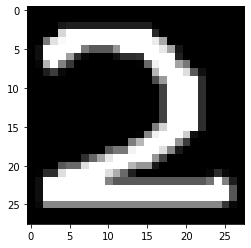

prediction result: 2


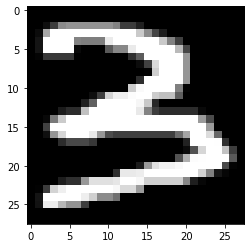

prediction result: 5


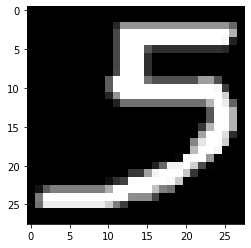

225

In [140]:
digits_value = digit_recognition(digit_img)
digits_value


### step 5.3 Construct the number from the list of single digits.    
